## Embedding space mapping

## Homework: Multilingual Embedding-based Machine Translation (8 points) + (2 points for class notebook)

**In this homework** **<font color='red'>YOU</font>** will make machine translation system without using parallel corpora, alignment, attention, 100500 depth super-cool recurrent neural network and all that kind superstuff.

But even without parallel corpora this system can be good enough (hopefully).

For our system we choose two languages: Spanish and English.

### Feel the difference!

(_pan_ vs. _pan_)

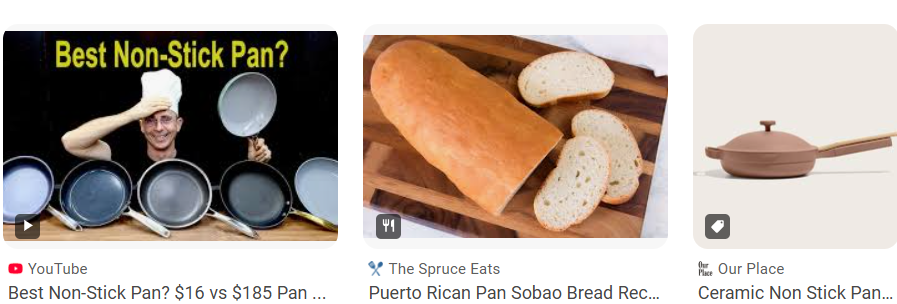

### Fragment of the Swadesh list for some languages

The Swadesh list is a lexicostatistical stuff (see, for example, https://en.wiktionary.org/wiki/Appendix:Spanish_Swadesh_list). It's named after American linguist Morris Swadesh and contains basic lexis. This list is used to define subgroupings of languages, its relatedness.


|	English |	Spanish	| French	| German | Italian|
|----------|----------|----------|---------|----------|
|	Mother	| Madre |	Mère	| Mutter | Madre|
|	Water |	Agua	| Eau	| Wasser | Acqua |
|Fire |	Fuego |	Feu |	Feuer | Fuoco |
|	Stone |	Piedra |	Pierre	| Stein | Pietra |

But the context distribution of these languages demonstrates even more invariance. And we can use this fact for our purposes.

The Swadesh list contains about 200 words and those would be enouth for close languages like Spanish and Italian. In this assignment, you will use about 2000 word pairs extracted randomly from [Shakespeare](https://github.com/xr09/shakespeare/tree/master/src/core) dictionary. Download files `en_sp_train.txt` and `en_sp_test.txt`.

## Data

In [2]:
import gensim
import numpy as np
from gensim.models import KeyedVectors

Load embeddings for English and Spanish from https://fasttext.cc/docs/en/crawl-vectors.html.

In [6]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

--2025-01-26 22:54:27--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.126, 18.238.176.19, 18.238.176.44, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  47.6MB/s    in 13s     

2025-01-26 22:54:40 (99.2 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [7]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz

--2025-01-26 22:54:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.126, 18.238.176.19, 18.238.176.44, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]
Saving to: ‘cc.es.300.vec.gz’

cc.es.300.vec.gz    100%[===================>]   1.20G   191MB/s    in 10s     

2025-01-26 22:54:56 (121 MB/s) - ‘cc.es.300.vec.gz’ saved [1285580896/1285580896]



In [8]:
# !gunzip cc.en.300.vec.gz
# !gunzip cc.es.300.vec.gz
!gunzip cc.en.300.vec.gz
!gunzip cc.es.300.vec.gz

In [10]:
en_emb = KeyedVectors.load_word2vec_format("cc.en.300.vec")

In [11]:
es_emb = KeyedVectors.load_word2vec_format("cc.es.300.vec")

In [12]:
en_emb.most_similar([en_emb["january"]], topn=10)

[('january', 0.9999999403953552),
 ('february', 0.9160889983177185),
 ('december', 0.9089956283569336),
 ('october', 0.8979066610336304),
 ('november', 0.8899590969085693),
 ('september', 0.8862048983573914),
 ('june', 0.8820876479148865),
 ('july', 0.860153317451477),
 ('april', 0.8336244821548462),
 ('august', 0.7743154764175415)]

In [13]:
es_emb.most_similar([es_emb["enero"]])

[('enero', 1.0),
 ('febrero', 0.9748411774635315),
 ('marzo', 0.9677975177764893),
 ('diciembre', 0.9676311612129211),
 ('abril', 0.9615138173103333),
 ('julio', 0.9596322178840637),
 ('noviembre', 0.9578107595443726),
 ('octubre', 0.9571518898010254),
 ('junio', 0.9564434289932251),
 ('septiembre', 0.9544821977615356)]

In [14]:
en_emb.most_similar([es_emb["enero"]])

[('premierVICTORIA', 0.26183149218559265),
 ('Zire', 0.25221550464630127),
 ('Musketier', 0.2521815598011017),
 ('Deletionist', 0.24645963311195374),
 ('SHFL', 0.245808944106102),
 ('PC-only', 0.24134483933448792),
 ('Multi-Camera', 0.24112267792224884),
 ('dual-booted', 0.24080190062522888),
 ('Voice-Over', 0.2405189722776413),
 ('theinquirer.net', 0.24040758609771729)]

Load small dictionaries for correspoinding words pairs as trainset and testset.

In [31]:
# Create matrices X and Y with Spanish and English word embeddings in rows of shape (n, 300)
def load_word_pairs(filename):
    es_en_pairs = []
    en_vectors = []
    es_vectors = []
    with open(filename, "r") as inpf:
        for line in inpf:
            en, es = line.rstrip().split()[1:]
            if es not in es_emb or en not in en_emb:
                continue
            es_en_pairs.append((es, en))
            en_vectors.append(en_emb[en])
            es_vectors.append(es_emb[es])
    return es_en_pairs, np.array(es_vectors), np.array(en_vectors)

In [33]:
!wget https://raw.githubusercontent.com/anton-selitskiy/RIT_LLM/main/Week01_embeddings/en_sp_train.txt -O en_sp_train.txt

es_en_train , X_train, Y_train = load_word_pairs("en_sp_train.txt")

--2025-01-27 00:02:34--  https://raw.githubusercontent.com/anton-selitskiy/RIT_LLM/main/Week01_embeddings/en_sp_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46126 (45K) [text/plain]
Saving to: ‘en_sp_train.txt’

en_sp_train.txt     100%[===================>]  45.04K  --.-KB/s    in 0.01s   

2025-01-27 00:02:35 (3.75 MB/s) - ‘en_sp_train.txt’ saved [46126/46126]



In [34]:
!wget https://raw.githubusercontent.com/anton-selitskiy/RIT_LLM/main/Week01_embeddings/en_sp_test.txt -O  en_sp_test.txt

es_en_test, X_test, Y_test = load_word_pairs("en_sp_test.txt")

--2025-01-27 00:02:53--  https://raw.githubusercontent.com/anton-selitskiy/RIT_LLM/main/Week01_embeddings/en_sp_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2448 (2.4K) [text/plain]
Saving to: ‘en_sp_test.txt’

en_sp_test.txt      100%[===================>]   2.39K  --.-KB/s    in 0s      

2025-01-27 00:02:53 (17.5 MB/s) - ‘en_sp_test.txt’ saved [2448/2448]



## Embedding space mapping

Let $x_i \in \mathrm{R}^d$ be the distributed representation of word $i$ in the source language, and $y_i \in \mathrm{R}^d$ is the vector representation of its translation. Our purpose is to learn such linear transform $W$ that minimizes euclidian distance between $Wx_i$ and $y_i$ for some subset of word embeddings. Thus we can formulate so-called Procrustes problem:

$$W^*= \arg\min_W \sum_{i=1}^n||Wx_i - y_i||^2$$
or
$$W^*= \arg\min_W ||WX^T - Y^T||^2_F$$

where $||*||_F$ - Frobenius norm.

In Greek mythology, Procrustes or "the stretcher" was a rogue smith and bandit from Attica who attacked people by stretching them or cutting off their legs, so as to force them to fit the size of an iron bed. We make same bad things with source embedding space. Our Procrustean bed is target embedding space.

![embedding_mapping.png](https://github.com/yandexdataschool/nlp_course/raw/master/resources/embedding_mapping.png)

![procrustes.png](https://github.com/yandexdataschool/nlp_course/raw/master/resources/procrustes.png)

But wait...$W^*= \arg\min_W \sum_{i=1}^n||Wx_i - y_i||^2$ looks like simple multiple linear regression (without intercept fit). So let's code.

In [35]:
from sklearn.linear_model import LinearRegression
  # YOUR CODE BELOW

# X_train = X_train.reshape(-1, 1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (1926, 300)
Y_train shape: (1926, 300)


In [36]:
# Create the linear regression model
mapping = LinearRegression(fit_intercept=False)

In [37]:
# Fit the model
mapping.fit(X_train, Y_train)


LinearRegression(fit_intercept=False)

Let's take a look at neigbours of the vector of word _"enero"_ (_"January"_ in English) after linear transform.

In [38]:
january = mapping.predict(es_emb["enero"].reshape(1, -1))
en_emb.most_similar(january)

[('June', 0.8955410122871399),
 ('July', 0.89244544506073),
 ('October', 0.8914619088172913),
 ('August', 0.8907102346420288),
 ('April', 0.8890923857688904),
 ('September', 0.8870711922645569),
 ('January', 0.8867405652999878),
 ('February', 0.8847365975379944),
 ('March', 0.8844079971313477),
 ('November', 0.8842158913612366)]

We can see that neighbourhood of this embedding cosists of different months, but right variant is on the ninth place.

As quality measure we will use precision top-1, top-5 and top-10 (for each transformed Ukrainian embedding we count how many right target pairs are found in top N nearest neighbours in Russian embedding space).

In [43]:
def precision(pairs, mapped_vectors, topn=1):
    """
    :args:
        pairs = list of right word pairs [(uk_word_0, ru_word_0), ...]
        mapped_vectors = list of embeddings (or matrix with embeddings in rows) after mapping from source embedding space to destination embedding space
        topn = the number of nearest neighbours in destination embedding space to choose from
    :returns:
        precision_val, float number, total number of words for those we can find right translation at top K.
    """
    assert len(pairs) == len(mapped_vectors)
    num_matches = 0
    for i, (_, target_word) in enumerate(pairs):
        # YOUR CODE HERE
        top_n_wrds = [word for word, _ in en_emb.most_similar(mapped_vectors[i], topn=topn)]
        if target_word in top_n_wrds:
            num_matches += 1

    precision_val = num_matches / len(pairs)
    return precision_val


In [44]:
assert precision([("enero", "January")], january, topn=3) == 0.0
assert precision([("enero", "January")], january, topn=9) == 1.0

In [45]:
assert precision(es_en_test, X_test) == 0.0
assert precision(es_en_test, Y_test) == 1.0

In [46]:
precision_top1 = precision(es_en_test, mapping.predict(X_test), 1)
precision_top10 = precision(es_en_test, mapping.predict(X_test), 10)

print(precision_top1, precision_top10)

assert precision_top1 >= 0.3
assert precision_top10 >= 0.6

0.39603960396039606 0.6336633663366337


## Making it better (orthogonal Procrustean problem)

It can be shown (see original paper) that a self-consistent linear mapping between semantic spaces should be orthogonal.
We can restrict transform $W$ to be orthogonal. Then we will solve next problem:

$$W^*= \arg\min_W ||WX^T - Y^T||^2_F \text{, where: } W^TW = I$$

$$I \text{- identity matrix}$$

Instead of making yet another regression problem we can find optimal orthogonal transformation using singular value decomposition. It turns out that optimal transformation $W^*$ can be expressed via SVD components:
$$X^TY=U\Sigma V^T\text{, singular value decompostion}$$
$$W^*=VU^T.$$

If we want the resulted embeddings in rows, then we should take
$$(WX^T)^T = XW^T.$$
It is easier to calculate $W^{*T}$ from SVD:
$$W^{*T}=UV^T.$$

In [ ]:
def learn_transform(X_train, Y_train):
    """
    :returns: W* transposed : float matrix[emb_dim x emb_dim] as defined in formulae above
    """
    # YOU CODE HERE


In [ ]:
W_transposed = learn_transform(X_train, Y_train)

In [ ]:
en_emb.most_similar([np.matmul(es_emb["enero"],W_transposed)])

In [ ]:
assert precision(es_en_test, np.matmul(X_test,W_transposed)) >= 0.4
#assert precision(es_en_test, np.matmul(X_test, W), 10) >= 0.6 #you could run it, but it's slow

## ES-EN Translator

Now we are ready to make simple word-based translator: for earch word in source language in shared embedding space we find the nearest in target language.


In [ ]:
with open("fairy_tale.txt", "r") as inpf:
    es_sentences = [line.rstrip().lower() for line in inpf]

In [ ]:
es_sentences[0].split()

['el', 'árbol', 'mágico']

In [ ]:
import string

In [ ]:
def translate(sentence):
    """
    :args:
        sentence - sentence/or paragraph in Spanish (str)
    :returns:
        translation - sentence/or paragraph in English (str) and the count of words from the es_en_train dictionary

    * find Spanish embedding for each word in sentence
    * transform Spanish embedding vectors
    * find nearest English word and replace
    """
    # YOUR CODE HERE


In [ ]:
assert translate("1 , 3")[0] == "1 , 3"
assert translate("sofía encontró una pequeña puerta")[0] == "kaspar found thing--a small door"

In [ ]:
for sentence in es_sentences:
    print("src: {}\ndst: {}\n".format(sentence, translate(sentence)))

Not so bad, right? We can easily improve translation using language model and not one but several nearest neighbours in shared embedding space. But next time.

## Would you like to learn more?

### Articles:
* [Exploiting Similarities among Languages for Machine Translation](https://arxiv.org/pdf/1309.4168)  - entry point for multilingual embedding studies by Tomas Mikolov (the author of W2V)
* [Offline bilingual word vectors, orthogonal transformations and the inverted softmax](https://arxiv.org/pdf/1702.03859) - orthogonal transform for unsupervised MT
* [Word Translation Without Parallel Data](https://arxiv.org/pdf/1710.04087)
* [Loss in Translation: Learning Bilingual Word Mapping with a Retrieval Criterion](https://arxiv.org/pdf/1804.07745)
* [Unsupervised Alignment of Embeddings with Wasserstein Procrustes](https://arxiv.org/pdf/1805.11222)

### Repos (with ready-to-use multilingual embeddings):
* https://github.com/facebookresearch/MUSE

* https://github.com/Babylonpartners/fastText_multilingual -